In [1]:
import pandas as pd
import optuna
import numpy as np
import warnings
import logging
import copy
import timeout_decorator

from lightgbm import LGBMClassifier
from sklearn import linear_model
from sklearn.svm import SVC

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold


logger = logging.getLogger()

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [3]:
class StopWhenPerfectScoreReached:
    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value == 1.0:
            print("Stopping study because perfect score is reached")
            study.stop()
            
@ignore_warnings(category=ConvergenceWarning)
def get_elasticnet_model(X_train: np.ndarray, y_train: np.ndarray, n_trials=100):

    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned)
    def objective(trial):
    
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])
        
        penalty = trial.suggest_categorical("penalty", ["elasticnet"])
        
        solver = trial.suggest_categorical("solver", ["saga"])

        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        
        logreg_c = trial.suggest_float("logreg_c", 1e-4, 1e2, log=True)
        
        weight = trial.suggest_categorical("weight", [None, "balanced"])

        max_iter = trial.suggest_int("max_iter", 1000, 10000, log=True)

        clf = linear_model.LogisticRegression(
                        C=logreg_c,
                        penalty=penalty,
                        solver=solver,
                        random_state=3866, 
                        max_iter=max_iter,
                        l1_ratio=l1_ratio,
                        class_weight=weight,
                        n_jobs=-1)

        try:

            with warnings.catch_warnings():
                
                warnings.filterwarnings("ignore")

                scores = cross_val_score(clf, 
                                        X_train, 
                                        y_train, 
                                        cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                        n_jobs=-1,
                                        scoring="f1")

                return np.median(scores).item()
            
        except Exception as e:
            raise optuna.TrialPruned(e)

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = linear_model.LogisticRegression(
        C=study.best_params["logreg_c"],
        penalty=study.best_params["penalty"],
        solver=study.best_params["solver"],
        random_state=3866, 
        max_iter=study.best_params["max_iter"], 
        l1_ratio=study.best_params["l1_ratio"],
        class_weight=study.best_params["weight"],
        n_jobs=-1)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        clf.fit(X_train, y_train)

    return clf, study.best_value

@ignore_warnings(category=ConvergenceWarning)
def get_svm_rbf_model(X_train, y_train, n_trials=500):
    
    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned)
    def objective(trial) -> float:
    
        kernel = trial.suggest_categorical("kernel",
                                           ["rbf"])
        
        weight = trial.suggest_categorical("weight",
                                           [None, "balanced"])
        
        gamma = trial.suggest_float("gamma", 1e-4, 1e4, log=True)
        
        logreg_c = trial.suggest_float("logreg_c", 1e-4, 1e4, log=True)
        
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])

        clf = SVC(kernel=kernel, 
                  class_weight=weight, 
                  C=logreg_c,
                  gamma=gamma,
                  random_state=3866, 
                  max_iter=-1,
                  probability=True)

        try:
            scores = cross_val_score(clf, 
                                     X_train, 
                                     y_train, 
                                     cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                     n_jobs=-1,
                                     scoring="f1")
                                     
            return np.median(scores).item()
            
        except Exception as e:
            logger.exception(e)
        
        return np.nan

    study = optuna.create_study(direction="maximize", 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = SVC(kernel=study.best_params["kernel"], 
              class_weight=study.best_params["weight"], 
              C=study.best_params["logreg_c"], 
              gamma=study.best_params["gamma"], 
              random_state=3866, 
              max_iter=-1,
              probability=True)

    clf.fit(X_train, y_train)

    return clf, study.best_value

@ignore_warnings(category=ConvergenceWarning)
def get_svm_linear_model(X_train, y_train, n_trials=500):

    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned) 
    def objective(trial) -> float:
    
        kernel = trial.suggest_categorical("kernel",
                                           ["linear"])
        
        weight = trial.suggest_categorical("weight",
                                           [None, "balanced"])
        
        gamma = trial.suggest_float("gamma", 1e-4, 1e4, log=True)
        
        logreg_c = trial.suggest_float("logreg_c", 1e-4, 1e4, log=True)
        
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])

        clf = SVC(kernel=kernel, 
                  class_weight=weight, 
                  C=logreg_c,
                  gamma=gamma,
                  random_state=3866, 
                  max_iter=-1)

        try:
            scores = cross_val_score(clf, 
                                     X_train, 
                                     y_train, 
                                     cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                     n_jobs=-1,
                                     scoring="f1")

            return np.median(scores).item()
            
        except Exception as e:
            logger.exception(e)
        
        return np.nan

    study = optuna.create_study(direction="maximize", 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = SVC(kernel=study.best_params["kernel"], 
              class_weight=study.best_params["weight"], 
              C=study.best_params["logreg_c"], 
              gamma=study.best_params["gamma"], 
              random_state=3866, 
              max_iter=-1)

    clf.fit(X_train, y_train)

    return clf, study.best_value


@ignore_warnings(category=ConvergenceWarning)
def get_lightgbm_model(X_train, y_train, n_trials=500):
    """
    Optimizes and returns a LightGBM classifier object

    Args:
        data (np.array): _description_
        labels (np.array): _description_
        n_trials (int, optional): Number of optimization trials. Defaults to 100.

    Returns:
        LGBMClassifier: Optimized instance of lightgbm classifier
    """

    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned)
    def objective(trial) -> float:
    
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])

        # Can't have more splits than positive cases
        if splits >= len(y_train[y_train == 1]):
            raise optuna.exceptions.TrialPruned()

        param = {
            "objective": "binary",
            "metric": 'binary_logloss',
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "is_unbalance": True,    # Assumes unbalanced because that's usually the case
            }

        clf = LGBMClassifier()
        clf.set_params(**param)
        
        try:

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                scores = cross_val_score(clf, 
                                        X_train, 
                                        y_train.ravel(), 
                                        cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                        n_jobs=-1,
                                        scoring="f1")

            return np.median(scores).item()
           
        except Exception as e:
            logger.exception(e)
            
        return np.nan

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = LGBMClassifier()
    param = copy.deepcopy(study.best_params)
    del param["splits"]
    clf.set_params(**param)
    clf.fit(X_train, y_train)

    return clf, study.best_value

In [4]:
def roll_genes(genes):
    mgenes = np.empty((genes.shape[0], genes.shape[0]), dtype=object)
    for i in range(genes.shape[0]):
        for j, (g1, g2) in enumerate(zip(genes, np.roll(genes, i))):
            mgenes[j, i] = f"{g2}:{g1}"
    return mgenes
    
def divs(array):
    matrix = np.zeros((array.shape[0], array.shape[0]))
    for i in range(array.shape[0]):
        matrix[:, i] = np.roll(array, i)
    return matrix

def col_div(col):
    denominator = col
    numerator = divs(denominator)
    diffs = numerator / denominator[:, np.newaxis]
    return diffs.flatten()

def fast(mat):
    
    mgenes = roll_genes(np.arange(len(mat)))
    
    matrix = pd.DataFrame(index=mgenes.flatten(), 
                          columns=range(mat.shape[1]))
    
    for i in range(mat.shape[1]):
        matrix.loc[:, i] = col_div(mat[i].values)
            
    return matrix


def calculate_ratios(log2tpm1):
    
    from sklearn import preprocessing

    tpm = (2**log2tpm1) - 1.0

    scaler = preprocessing.MinMaxScaler(feature_range=(1, 100))
    norm = pd.DataFrame(index=tpm.index, columns=log2tpm1.columns)

    gene_bounds = pd.DataFrame(index=tpm.index, columns=['q1', 'q2', 'q3', 'upper_outlier', 'lower_outlier'])

    for gene in norm.index.values:

        try:

            vec = tpm.loc[gene, :].values.reshape(-1, 1)
            q1 = np.percentile(vec, 25)
            q2 = np.percentile(vec, 50)
            q3 = np.percentile(vec, 75)

            upper_outlier = q3 + 1.5 * (q3 - q1)
            lower_outlier = q1 - 1.5 * (q3 - q1)

            gene_bounds.loc[gene, :] = [q1, q2, q3, upper_outlier, lower_outlier]

            idx, _ = np.where(vec > upper_outlier)
            vec[idx] = upper_outlier

            idx, _ = np.where(vec < lower_outlier)
            vec[idx] = lower_outlier

            norm.loc[gene, :] = scaler.fit_transform(vec).flatten()

        except Exception as e:
            print(e)
            
    ratio = fast(pd.DataFrame(norm.values))
    ratio = ratio.astype(np.float64)
    ratio.columns = tpm.columns
    return ratio, norm

In [16]:
pd.DataFrame(trainX)

,TotalScore
nonresponders172,-0.049153
nonresponders176,-0.013884
nonresponders82,-0.101917
nonresponders33,-0.229504
nonresponders8,-0.098694
...,...
nonresponders93,0.054370
responders198,0.053117
nonresponders31,-0.078579
nonresponders4,0.120707


In [21]:
#
# Train
#
trainX = pd.read_csv("../../../data/enrichment/synthetic-train-minmax-eff-0.5-ndiff-10-frac-0.1-2023-08-14-ratio-gene-set.tsv",
                     sep='\t', 
                     index_col=0)

trainX = pd.DataFrame(trainX["TotalScore"]).T

trainX = trainX.sample(frac=1.0, axis=1)

trainY = np.array([0 if x.startswith("nonresponders") else 1 for x in trainX.columns])


#
# Test
#
testX = pd.read_csv("../../../data/enrichment/synthetic-test-minmax-eff-0.5-ndiff-10-frac-0.1-2023-08-14-ratio-gene-set.tsv",
                    sep='\t', 
                    index_col=0)

testX = pd.DataFrame(testX["TotalScore"]).T

testX = testX.sample(frac=1.0, axis=1)

testY = np.array([0 if x.startswith("nonresponders") else 1 for x in testX.columns])

# Elastic Net

In [22]:
# Elastic Net
elastic_net_model, elastic_net_model_best_value = get_elasticnet_model(trainX.values.T, trainY, n_trials=100)

In [23]:
# Elastic Net Best Value
elastic_net_model_best_value

0.7493734335839599

In [24]:
# Elastic Net Of of Sample Prediction
elastic_net_test_yhat = elastic_net_model.predict(testX.values.T)
f1_score(testY, elastic_net_test_yhat)

0.509090909090909

# RBF SVM

In [25]:
rbf_svm_model, rbf_svm_model_best_value = get_svm_rbf_model(trainX.values.T, trainY, n_trials=100)

In [26]:
rbf_svm_model_best_value

0.8333333333333333

In [27]:
rbf_svm_test_yhat = rbf_svm_model.predict(testX.values.T)
f1_score(testY, rbf_svm_test_yhat)

0.6206896551724138

# Linear SVM

In [28]:
linear_svm_model, linear_svm_model_best_value = get_svm_linear_model(trainX.values.T, trainY, n_trials=100)

In [29]:
linear_svm_model_best_value

0.8571428571428571

In [30]:
linear_svm_test_yhat = linear_svm_model.predict(testX.values.T)
f1_score(testY, linear_svm_test_yhat)

0.7096774193548387

In [32]:
trainX

,nonresponders153,nonresponders67,nonresponders164,nonresponders130,nonresponders133,nonresponders38,responders190,nonresponders154,nonresponders179,nonresponders39,...,nonresponders116,nonresponders50,nonresponders73,nonresponders173,nonresponders172,nonresponders17,nonresponders147,nonresponders141,nonresponders102,nonresponders26
TotalScore,-0.031402,-0.059259,0.018832,-0.120708,-0.122042,-0.295675,0.198025,-0.088225,0.062013,-0.002232,...,-0.039458,-0.108542,-0.040009,-0.175891,-0.049153,0.016765,-0.026883,-0.021206,-0.086513,-0.170936


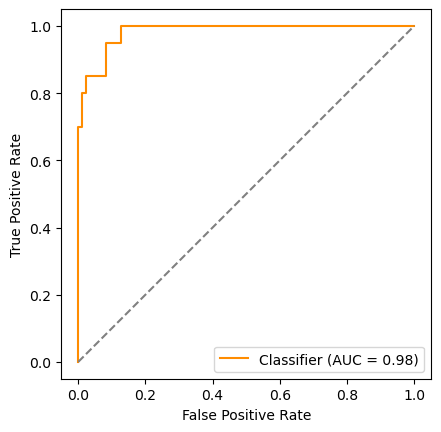

In [41]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    trainY,
    trainX.loc["TotalScore"],
    color="darkorange",
)

plt.plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

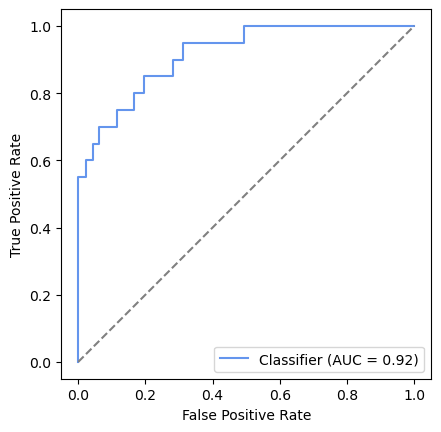

In [43]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    testY,
    testX.loc["TotalScore"],
    color="cornflowerblue",
)

plt.plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()